# Project: Financial time series forecasting

The following project is an individual piece of work and you not allowed to share your solution with anyone else.
Ver. 4.0 Date: 10.09.2021

- The aim of the project is that you learn how to set up an analytics project end-to-end. A secondary aim is that you understand how to work with a time series dataset and forecast based on such data. Third aim is that you gain an insight into how to interpret data and results.

- **The solution must address each grade in the written order.** Therefore, to complete grade two you must have completed grade one without errors, and so on.

- Your code will be tested on [https://notebooks.csc.fi](https://notebooks.csc.fi). (General-purpose environment with Jupyter and Python Machine Learning Libraries: scikit-learn, scipy, Theano, Keras and pandas.) If it doesn't run there it will not be accepted.

- Clean up and format nicely your code before the subbmission. Spaghetti-draft-style with code repetitions may affect your grade.

- You are advised to reserve about 60 hours of self-studies for this project.

- Unintentionally, there may be information missing in the description, please go through the description early in advance so that you have time to ask for assistance.


In [1]:
# First upgrade the environment.
# https://pypi.org/project/yfinance
import pip
from subprocess import run
# add what you will need
modules =[
#     'pandas_datareader',
#     'yfinance',
    'pandas_market_calendars',
    'plotly', 
    'numpy',
    'sklearn',
    'pandas'
]
proc = run(f'pip install {" ".join(modules)} --upgrade --no-input', 
       shell=True, 
       text=True, 
       capture_output=True, 
       timeout=120) #a couple of minutes
print(proc.stderr)

In [2]:
## Run this if you need to check your modules
# import pip
# from pip._internal.utils.misc import get_installed_distributions
# pkgs = ''.join(str(get_installed_distributions(local_only=True)))

# with open("modules.txt", "a") as file_object:
#     for p in (get_installed_distributions(local_only=True)):
#         file_object.write(str(p)+'\n')
#         print(str(p))
# file_object.close()

In [3]:
import pandas as pd
from pathlib import Path
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter, StrMethodFormatter
%matplotlib inline

import plotly as ply
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sklearn
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

from functools import reduce
from operator import mul
from pprint import PrettyPrinter
pprint = PrettyPrinter().pprint

<a id='g1'></a>

## Implement a complete process for forecasting a single stock.

You should do the following steps:
- Use the [EURUSD data set](https://people.arcada.fi/~parland/hjd5_8amp_Gt3/EURUSD1m.zip) (52Mb)
- Alternatively, you can use an API to fetch your own currency or crypto data. Using the API you must specify how to install any library and share any token keys needed for downloading data. You must access high ganularity data e.g. 1min, and then follow instructions below. 

- Subsample data to one day timesteps, be sure to also get data from weekends.

- Create a Label column for your forecast, by shifting the Close value 1 step. You will predict one day ahead.

- Split data into 80/20 (train/test). Be carefull: you are splitting a time series.


- [Normalize or standardize](https://scikit-learn.org/stable/modules/preprocessing.html) wisely so you don't allow information leakage to the test subset. Note, that utility class [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html) performs scaling **individual samples to have unit norm**, so it is not useful for certain tasks. Write your own function or check [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) or [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 

Please check in which order you perform split and scale.

    - Data → X, y → split → scale
    - Data → split → scale → X_test, y_test ; X_train, y_train
    
**Note! when we transform data like this it means that the forecast should then be transformed back into the original form (price). Hence, save the parameters used to normalize or standardize so that you can de-normalize.    

- Calculate the technical analysis feature [Larry William’s %R](https://www.investopedia.com/terms/w/williamsr.asp) from the paper [Predicting the Direction of Stock Market Index Movement Using an Optimized Artificial Neural Network Model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4873195) (implement in code, insert values in a complementary column). 

**Note that you need to implement your own calculation of each feature and be able to explain the code.**

- Drop other data than the Close and the features for training and inference. You don't want to feed time-column into the model, it's usually not a feature to base your prediction on. 

- Fit a [linear model](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) to the training data

- Forecast one day ahead based on the test data

- Calculate the [R² error](https://en.wikipedia.org/wiki/Coefficient_of_determination) on both the training data set and the test. Please format numbers to four [significant digits](https://en.wikipedia.org/wiki/Significant_figures). As a check you may note that values suppose to be in the range 0.975 … 0.993 for test and 0.995 … 0.998 for train. If you get R² error outside these ranges it **indicates** that you are highly likely to have an error in your program logic.

**NB! You may also get an expected result by performing several cumulative mistakes.**  

$$ (2+1)\times 3 = ?$$

$$ \text{Erroneous attempt} $$
$$ 2+1=4 $$
$$ 4\times 3 = 9 $$
$$ \text{Answer: } 9 $$

**The objective of this assignment is not to achieve a correct result but to achieve the result correctly.**

- Compare the R² errors for test and train and explain the outcome. 

- Extra: Test your model (get R² errors for test and train without LW%R, just Close column). Comment and explain the result. A reasonable explanation will compensate for one error in the following grades.


In [4]:
data = pd.read_csv('https://people.arcada.fi/~parland/hjd5_8amp_Gt3/EURUSD1m.zip',\
                       compression='zip', parse_dates={"DateTime":["Date","Timestamp"]})
data = data.set_index(data.DateTime).drop(['DateTime'], axis=1)
data.head()

Open     High      Low    Close     Volume
DateTime                                                          
2010-01-01 11:00:00  1.43327  1.43335  1.43319  1.43335  56.299999
2010-01-01 11:01:00  1.43333  1.43333  1.43318  1.43327  82.100001
2010-01-01 11:02:00  1.43328  1.43333  1.43319  1.43333  86.900000
2010-01-01 11:03:00  1.43325  1.43333  1.43319  1.43326  68.899999
2010-01-01 11:04:00  1.43326  1.43333  1.43319  1.43319  45.300000

In [5]:
data_daily = data.resample('D').agg({'Open':'first','High':'max','Low':'min','Close':'last','Volume':'sum'}).dropna().copy()
data_daily

Open     High      Low    Close         Volume
DateTime                                                     
2010-01-01  1.43327  1.43356  1.43207  1.43335   39761.000053
2010-01-03  1.43024  1.43359  1.42951  1.43141    3001.600003
2010-01-04  1.43143  1.44556  1.42559  1.44244   80019.400094
2010-01-05  1.44238  1.44834  1.43445  1.43634   79887.100067
2010-01-06  1.43638  1.44342  1.42807  1.44005   80971.800085
...             ...      ...      ...      ...            ...
2019-12-26  1.10944  1.11088  1.10821  1.11012   52487.634115
2019-12-27  1.11013  1.11883  1.10987  1.11713  124575.902401
2019-12-29  1.11736  1.11839  1.11718  1.11813    3216.499400
2019-12-30  1.11812  1.12207  1.11806  1.12013  130773.875147
2019-12-31  1.12013  1.12283  1.11987  1.12277   44014.460085

[3128 rows x 5 columns]

In [6]:
def LWR (df, window=10):
    Hw = df['High'].rolling(window).max()
    Lw = df['Low'] .rolling(window).min()
    C   = df['Close']
    return 100 * (Hw - C) / (Hw - Lw)

In [7]:
data_daily['LWR'] = LWR(data_daily, window=10)

In [8]:
data_daily.head()

Open     High      Low    Close        Volume  LWR
DateTime                                                         
2010-01-01  1.43327  1.43356  1.43207  1.43335  39761.000053  NaN
2010-01-03  1.43024  1.43359  1.42951  1.43141   3001.600003  NaN
2010-01-04  1.43143  1.44556  1.42559  1.44244  80019.400094  NaN
2010-01-05  1.44238  1.44834  1.43445  1.43634  79887.100067  NaN
2010-01-06  1.43638  1.44342  1.42807  1.44005  80971.800085  NaN

In [9]:
model_data=data_daily.drop(['Open', 'High', 'Low', 'Volume'], axis=1)

In [10]:
model_data.head()

Close  LWR
DateTime                
2010-01-01  1.43335  NaN
2010-01-03  1.43141  NaN
2010-01-04  1.44244  NaN
2010-01-05  1.43634  NaN
2010-01-06  1.44005  NaN

In [11]:
model_data['Label']=data_daily['Close'].shift(-1) # shift by one day
model_data=model_data.dropna()
model_data.head()

Close        LWR    Label
DateTime                               
2010-01-12  1.44750  26.476510  1.45215
2010-01-13  1.45215  17.974058  1.44982
2010-01-14  1.44982  25.169858  1.43849
2010-01-15  1.43849  61.238604  1.43665
2010-01-17  1.43665  67.022949  1.44039

In [12]:
#define target variable
X, Y = model_data.drop(columns=['Label']), model_data[['Label']]

In [13]:
# Train test split
split_percent=0.8
split_indx = int(len(model_data) * split_percent)
X_train, X_test = X.iloc[:split_indx], X.iloc[split_indx:]
Y_train, Y_test = Y.iloc[:split_indx], Y.iloc[split_indx:]

In [14]:
# Scale and fit
scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
lin_model = LinearRegression().fit(X_train_scaled, Y_train)
#train_score = lin_model.score(X_train_scaled, Y_train)
#test_score  = lin_model.score(X_test_scaled, Y_test)
print("Trained set accuracy: {:.4f}".format(lin_model.score(X_train_scaled, Y_train)))
print("Test set accuracy: {:.4f}".format(lin_model.score(X_test_scaled, Y_test)))

Trained set accuracy: 0.9965
Test set accuracy: 0.9898


In [15]:
from sklearn.metrics import r2_score

Y_pred = lin_model.predict(X_test_scaled)
r_squared = r2_score(Y_test,Y_pred)
adjusted_r_squared = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print('Adjusted R^Score: {:.4f}'.format(adjusted_r_squared))

Adjusted R^Score: 0.9898


In [16]:
# Here with this simple method, and using limited features, the R2 scores proabaly don't change that much

### **Larry William’s %R**

$ (H_n − C_t)/(H_n − L_n)\times100 $

### Coefficient of determination ($R^2$)

$$R^2 = 1 - \frac {SSResid}{SSTot}$$

#### Residual Sum of Squares: $SSResid = \sum_{i} (y_i - \hat{y_i})^2$

#### Total Sum of Squares: $SSTot = \sum_{i} (y_i - \bar{y})^2$

#### A baseline model, which always predicts $\bar {y}$, will have $R^2 = 0$

Below is an example code for a Disparity Index feature calculation for 5 days = Ct/MA5 × 100
[See explanation](https://www.investopedia.com/terms/d/disparityindex.asp)

In [17]:

#def disparity_5(df):
    #return 100 * df['close'] / df['close'].rolling(window=5).mean()

#df['Disparity_5'] = disparity_5(df)

<a id='g2'></a>

## Illustrate data using plotly (or other) library

- Calculate an additional feature [Stochastic slow %D](https://www.investopedia.com/ask/answers/05/062405.asp)
- Create a figure based on OHLC candles **covering the test period** (the 20% of data)
- Add a line to the chart that illustrates the *label* (actual data) and the *forecast* (so candels and lines are in the same figure. The lines should have different colors and include names of the series.
- Add **subplot(s)** with the LW%R and Stochastic slow %D features, below the figure with OHLC, label and forecast, so we can see all time-aligned. Don't forget to sclae back the predicted values to the original range.
- What patterns can you observe from the line figure?

# Stochastic %K	
<br>
<span style='font-size:20px'>
$\frac{(C_t − L_n)}{(H_n − L_n)}\times100$
</span>
    
### Stochastic %D
<br>
<span style='font-size:20px'>
$\sum\nolimits_{i=0}^{n-1}\frac{\%K_{t-i}}n$
</span>
    
### Stochastic slow %D
<br>
<span style='font-size:25px'>
$\frac{\sum_{i=0}^{n-1}\%D_{t-i}}n$
</span>

In [18]:
data_daily.head()

Open     High      Low    Close        Volume  LWR
DateTime                                                         
2010-01-01  1.43327  1.43356  1.43207  1.43335  39761.000053  NaN
2010-01-03  1.43024  1.43359  1.42951  1.43141   3001.600003  NaN
2010-01-04  1.43143  1.44556  1.42559  1.44244  80019.400094  NaN
2010-01-05  1.44238  1.44834  1.43445  1.43634  79887.100067  NaN
2010-01-06  1.43638  1.44342  1.42807  1.44005  80971.800085  NaN

In [19]:
# Calculate additional feature %D
k_period = 14
d_period = 3
# Add a "n_high" column with max value of previous 14 periods
data_daily['n_high'] = data_daily['High'].rolling(k_period).max()
# Add an "n_low" column with min value of previous 14 periods
data_daily['n_low'] = data_daily['Low'].rolling(k_period).min()
# Use the min/max values to calculate the %k (as a percentage)
data_daily['%K'] = (data_daily['Close'] - data_daily['n_low']) * 100 / (data_daily['n_high'] - data_daily['n_low'])
# Use the %k to calculates a SMA over the past 3 values of %k
data_daily['%D'] = data_daily['%K'].rolling(d_period).mean()

In [20]:
# Create a data frame of label and forecast values.
actual_forecast_data = Y_test.copy()
actual_forecast_data['Forecast']=Y_pred
actual_forecast_data.head()

Label  Forecast
DateTime                     
2018-01-02  1.20107  1.206123
2018-01-03  1.20664  1.201074
2018-01-04  1.20304  1.206622
2018-01-05  1.20370  1.203038
2018-01-07  1.19698  1.203695

In [21]:
# Merge daily data with %D and forecast data together to make a data frame covering the 20% test period
join_data=actual_forecast_data.join(data_daily, how='left')

In [22]:
join_data.head()

Label  Forecast     Open     High      Low    Close  \
DateTime                                                            
2018-01-02  1.20107  1.206123  1.20105  1.20811  1.20078  1.20614   
2018-01-03  1.20664  1.201074  1.20614  1.20638  1.20011  1.20107   
2018-01-04  1.20304  1.206622  1.20108  1.20889  1.20044  1.20664   
2018-01-05  1.20370  1.203038  1.20663  1.20829  1.20205  1.20304   
2018-01-07  1.19698  1.203695  1.20265  1.20389  1.20259  1.20370   

                   Volume        LWR   n_high    n_low         %K         %D  
DateTime                                                                      
2018-01-02  197155.910377   7.456472  1.20811  1.17377  94.263250  93.256328  
2018-01-03  194931.660267  26.646480  1.20811  1.17420  79.239162  89.452722  
2018-01-04  210213.430272   9.146341  1.20889  1.17764  92.800000  88.767471  
2018-01-05  189702.350222  23.780488  1.20889  1.18169  78.492647  83.510603  
2018-01-07    5754.060013  21.410891  1.20889  1.18169  80.919118  84.070588

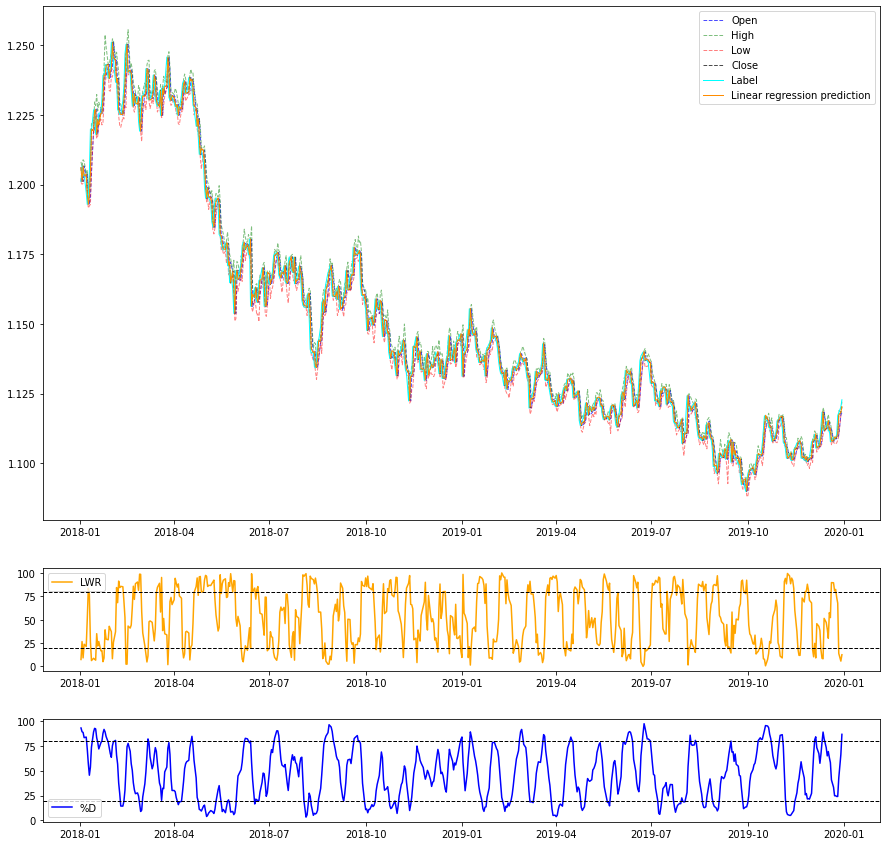

In [23]:
# Version 01
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15), gridspec_kw={'height_ratios': [5, 1, 1]})
ax1.plot(join_data.Open, color = 'blue', linewidth = 1, label = 'Open', alpha=0.7, linestyle = '--')
ax1.plot(join_data.High, color = 'green', linewidth = 1, label = 'High', alpha=0.5, linestyle = '--')
ax1.plot(join_data.Low, color = 'red', linewidth = 1, label = 'Low', alpha=0.5, linestyle = '--')
ax1.plot(join_data.Close, color = 'black', linewidth = 1, label = 'Close', alpha=0.7, linestyle = '--')
ax1.plot(join_data.Label, color = 'cyan', linewidth = 1, label = 'Label', alpha=1)
ax1.plot(join_data.Forecast, color = 'darkorange', linewidth = 1, label = 'Linear regression prediction', alpha=1)
ax1.legend()
ax2.plot(join_data['LWR'], color = 'orange', linewidth = 1.5, label = 'LWR')
ax2.axhline(80, color = 'black', linewidth = 1, linestyle = '--')
ax2.axhline(20, color = 'black', linewidth = 1, linestyle = '--')
ax2.legend()
ax3.plot(join_data['%D'], color = 'blue', linewidth = 1.5, label = '%D')
ax3.axhline(80, color = 'black', linewidth = 1, linestyle = '--')
ax3.axhline(20, color = 'black', linewidth = 1, linestyle = '--')
ax3.legend()
fig.show()

# Generally, the area above 80 indicates an overbought region, while the area below 20 is considered an oversold region. A sell signal is given when the oscillator is above the 80 level and then crosses back below 80. Conversely, a buy signal is given when the oscillator is below 20 and then crossed back above 20. 80 and 20 are the most common levels used but can be adjusted as needed.

# LW%R values are defined at scales 0 to -100, and many people add 100 to the score. In either way, it gives the message it is supposed to give

# There is an opposite trend/relationship between LW%R and %D. Alternatively, negative scaled LW%R shows same trend and %D.

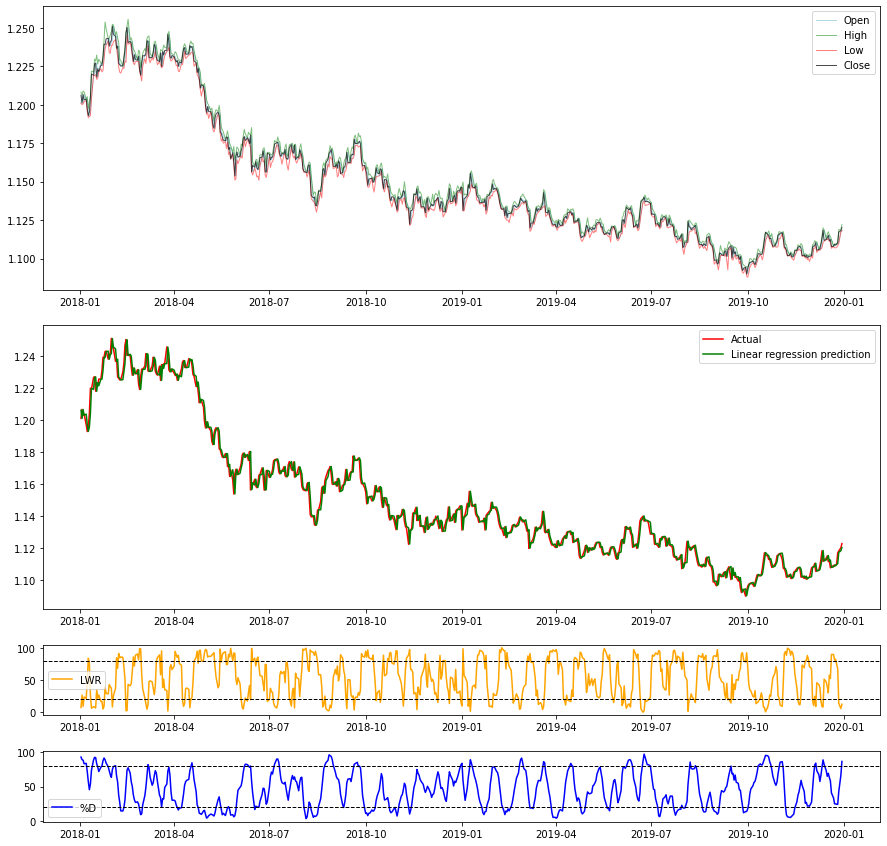

In [24]:
# Version 02 (here the actual and forecast lines are separated for another version of this visualization)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,15), gridspec_kw={'height_ratios': [4, 4, 1, 1]})
ax1.plot(join_data.Open, color = 'lightblue', linewidth = 1, label = 'Open', alpha=1)
ax1.plot(join_data.High, color = 'green', linewidth = 1, label = 'High', alpha=0.5)
ax1.plot(join_data.Low, color = 'red', linewidth = 1, label = 'Low', alpha=0.5)
ax1.plot(join_data.Close, color = 'black', linewidth = 1, label = 'Close', alpha=0.7)
ax1.legend()
ax2.plot(join_data.Label, color = 'red', label = 'Actual', alpha=1)
ax2.plot(join_data.Forecast, color = 'green', label = 'Linear regression prediction', alpha=1)
ax2.legend()
ax3.plot(join_data['LWR'], color = 'orange', linewidth = 1.5, label = 'LWR')
ax3.axhline(80, color = 'black', linewidth = 1, linestyle = '--')
ax3.axhline(20, color = 'black', linewidth = 1, linestyle = '--')
ax3.legend()
ax4.plot(join_data['%D'], color = 'blue', linewidth = 1.5, label = '%D')
ax4.axhline(80, color = 'black', linewidth = 1, linestyle = '--')
ax4.axhline(20, color = 'black', linewidth = 1, linestyle = '--')
ax4.legend()
fig.show()

In [25]:
# Version 3
fig = make_subplots(rows=3, cols=1)  

fig.append_trace(
    go.Scatter(
        x=join_data.index,
        y=join_data['LWR'],
        name='LWR'), row=1, col=1)

fig.append_trace(
    go.Scatter(
        x=join_data.index,
        y=join_data['%D'],
        name='%D'), row=2, col=1)

fig.append_trace(
    go.Candlestick(
        x=join_data.index,
        open=join_data.Open,
        high=join_data.High,
        low=join_data.Low,
        close=join_data.Close,
        increasing_line_color='green',
        decreasing_line_color='red',
        showlegend=False), row=3, col=1)

fig.append_trace(
    go.Scatter(
        x=join_data.index,
        y=join_data['Label'],
        line=dict(color='blue'),
        name='Label'), row=3, col=1)

fig.append_trace(
    go.Scatter(
        x=join_data.index,
        y=join_data['Forecast'],
        line=dict(color='black'),
        name='Linear regression prediction'), row=3, col=1)

fig.show()



In [26]:
# Make separate OHLC candles for better visualization
fig = make_subplots(rows=2, cols=1)  
fig = go.Figure(data=go.Ohlc(x=join_data.index,
                    open=join_data.Open,
                    high=join_data.High,
                    low=join_data.Low,
                    close=join_data.Close))
fig.show()

<a id='g3'></a>

- Calculate additional feature [RSI (relative strength index)](https://www.investopedia.com/terms/r/rsi.asp)
- Add the feature as a subplot to the figure in the previos step
- Set up an [ElasticNet](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net) (**not** an [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)) model
- Fit/train the ElasticNet to the training data
- Forecast and calculate the R² error on both the training data set and the test
- Add your new *forecast* line to the previos figure, so the predictions from both models are placed over each other and can be compared
- Compare the errors and explain the outcome

### RSI
<br>
<span style='font-size:25px'>
$100-\frac{100}{\left(1+\frac{\frac{\sum_{i=0}^{n-1}Up_{t-i}}{\text{n}}}{\frac{\sum_{i=0}^{n-1}Dw_{t-i}}{\text{n}}}\right)} $
    </span>

Example:
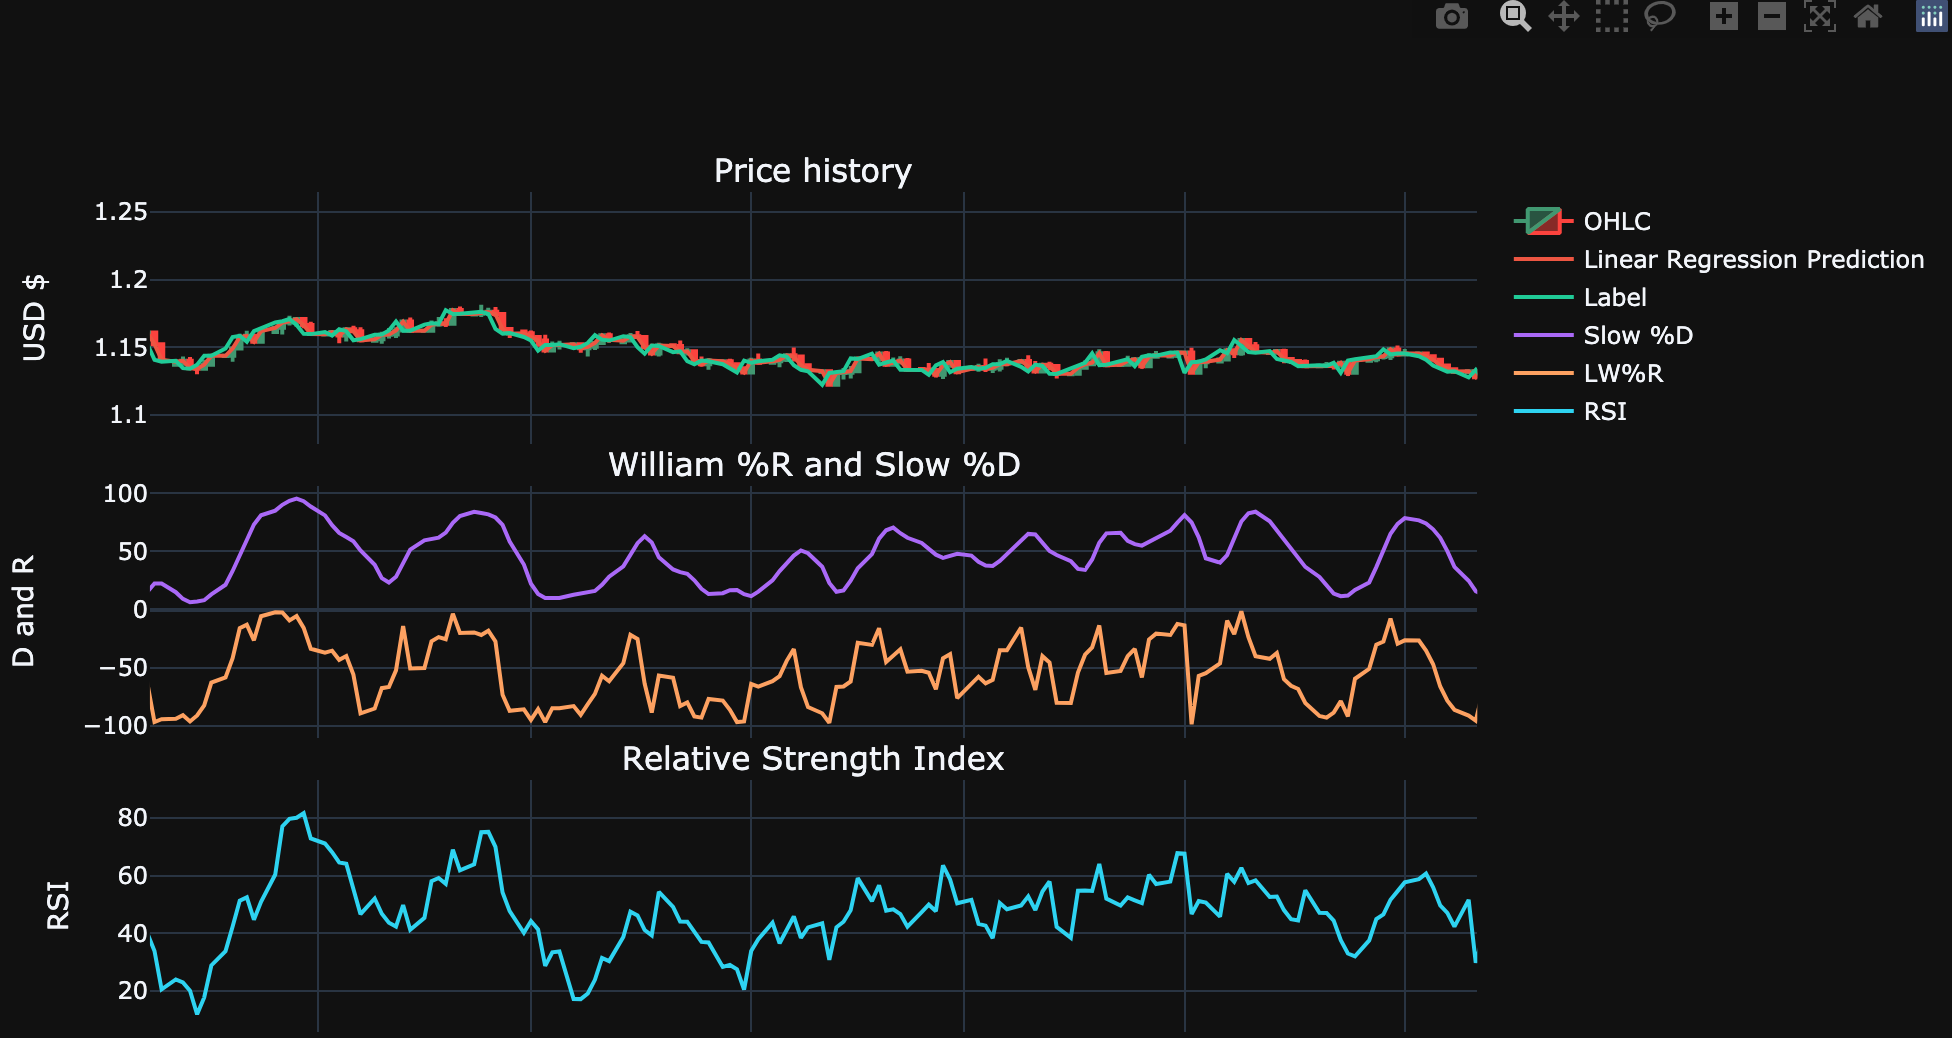

In [27]:
from sklearn.linear_model import Ridge
ridge_model=Ridge(alpha=0.1).fit(X_train_scaled, Y_train)
print("Trained set accuracy by Ridge: {:.4f}".format(ridge_model.score(X_train_scaled, Y_train)))
print("Test set accuracy by Ridge: {:.4f}".format(ridge_model.score(X_test_scaled, Y_test)))

Trained set accuracy by Ridge: 0.9965
Test set accuracy by Ridge: 0.9898


In [28]:
Y_pred_ridge = ridge_model.predict(X_test_scaled)
r_squared_ridge = r2_score(Y_test,Y_pred_ridge)
adjusted_r_squared_ridge = 1 - (1-r_squared_ridge)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print('Adjusted R^Score by Ridge: {:.4f}'.format(adjusted_r_squared_ridge))

Adjusted R^Score by Ridge: 0.9898


In [29]:
join_data['Forecast_ridge']=Y_pred_ridge

In [30]:
join_data.head()

Label  Forecast     Open     High      Low    Close  \
DateTime                                                            
2018-01-02  1.20107  1.206123  1.20105  1.20811  1.20078  1.20614   
2018-01-03  1.20664  1.201074  1.20614  1.20638  1.20011  1.20107   
2018-01-04  1.20304  1.206622  1.20108  1.20889  1.20044  1.20664   
2018-01-05  1.20370  1.203038  1.20663  1.20829  1.20205  1.20304   
2018-01-07  1.19698  1.203695  1.20265  1.20389  1.20259  1.20370   

                   Volume        LWR   n_high    n_low         %K         %D  \
DateTime                                                                       
2018-01-02  197155.910377   7.456472  1.20811  1.17377  94.263250  93.256328   
2018-01-03  194931.660267  26.646480  1.20811  1.17420  79.239162  89.452722   
2018-01-04  210213.430272   9.146341  1.20889  1.17764  92.800000  88.767471   
2018-01-05  189702.350222  23.780488  1.20889  1.18169  78.492647  83.510603   
2018-01-07    5754.060013  21.410891  1.20889  1.18169  80.919118  84.070588   

            Forecast_ridge  
DateTime                    
2018-01-02        1.206125  
2018-01-03        1.201077  
2018-01-04        1.206625  
2018-01-05        1.203041  
2018-01-07        1.203698

In [31]:
len(join_data)

624

In [32]:
# Calculate RSI
delta = data_daily['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down

data_daily['RSI'] = 100 - (100/(1 + rs))
data_daily.tail()

Open     High      Low    Close         Volume        LWR  \
DateTime                                                                   
2019-12-26  1.10944  1.11088  1.10821  1.11012   52487.634115  67.712177   
2019-12-27  1.11013  1.11883  1.10987  1.11713  124575.902401  13.923014   
2019-12-29  1.11736  1.11839  1.11718  1.11813    3216.499400   5.733006   
2019-12-30  1.11812  1.12207  1.11806  1.12013  130773.875147  12.556634   
2019-12-31  1.12013  1.12283  1.11987  1.12277   44014.460085   0.370142   

             n_high    n_low         %K         %D        RSI  
DateTime                                                       
2019-12-26  1.11995  1.10662  26.256564  24.209564  52.151783  
2019-12-27  1.11995  1.10662  78.844711  42.739196  63.088379  
2019-12-29  1.11883  1.10662  94.266994  66.456090  64.340533  
2019-12-30  1.12207  1.10662  87.443366  86.851690  66.768587  
2019-12-31  1.12283  1.10662  99.629858  93.780073  69.701279

In [33]:
#Join the new forecast by Ridge into the dataframe
actual_forecast_data['Forecast_ridge']=Y_pred_ridge
actual_forecast_data.head()

Label  Forecast  Forecast_ridge
DateTime                                     
2018-01-02  1.20107  1.206123        1.206125
2018-01-03  1.20664  1.201074        1.201077
2018-01-04  1.20304  1.206622        1.206625
2018-01-05  1.20370  1.203038        1.203041
2018-01-07  1.19698  1.203695        1.203698

In [34]:
# Join the predicted Ridge forecast and RSI to the main data frame (test subset)
join_data_rsi=actual_forecast_data.join(data_daily, how='left')

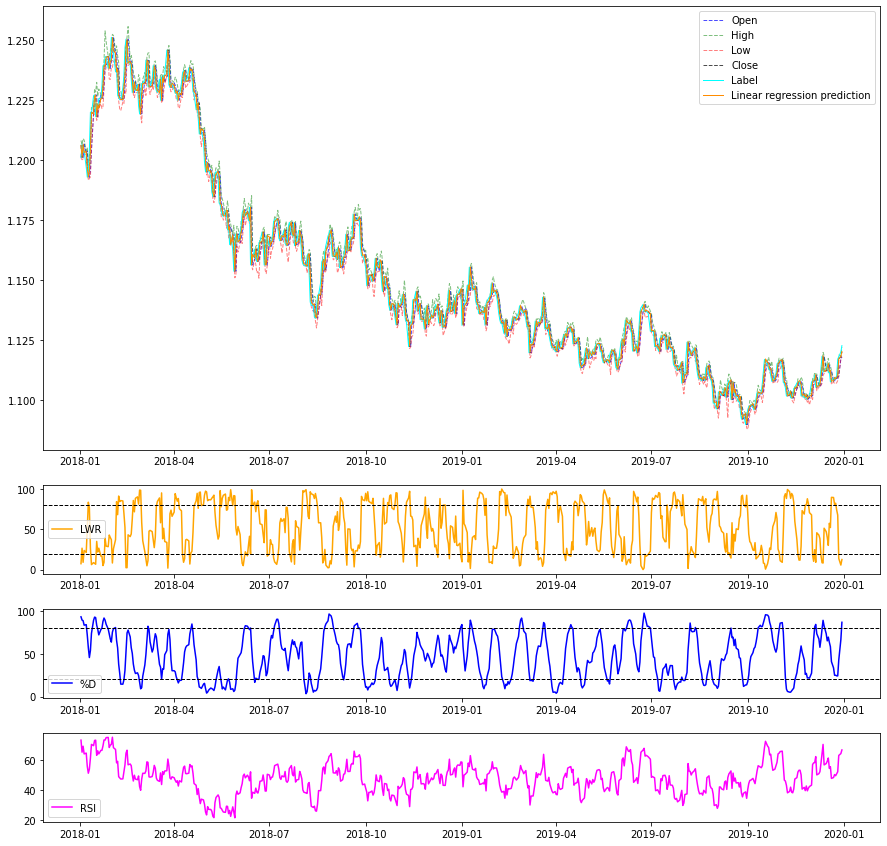

In [35]:
# Version 01
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,15), gridspec_kw={'height_ratios': [5, 1, 1, 1]})
ax1.plot(join_data_rsi.Open, color = 'blue', linewidth = 1, label = 'Open', alpha=0.7, linestyle = '--')
ax1.plot(join_data_rsi.High, color = 'green', linewidth = 1, label = 'High', alpha=0.5, linestyle = '--')
ax1.plot(join_data_rsi.Low, color = 'red', linewidth = 1, label = 'Low', alpha=0.5, linestyle = '--')
ax1.plot(join_data_rsi.Close, color = 'black', linewidth = 1, label = 'Close', alpha=0.7, linestyle = '--')
ax1.plot(join_data_rsi.Label, color = 'cyan', linewidth = 1, label = 'Label', alpha=1)
ax1.plot(join_data_rsi.Forecast, color = 'darkorange', linewidth = 1, label = 'Linear regression prediction', alpha=1)
ax1.legend()
ax2.plot(join_data_rsi['LWR'], color = 'orange', linewidth = 1.5, label = 'LWR')
ax2.axhline(80, color = 'black', linewidth = 1, linestyle = '--')
ax2.axhline(20, color = 'black', linewidth = 1, linestyle = '--')
ax2.legend()
ax3.plot(join_data_rsi['%D'], color = 'blue', linewidth = 1.5, label = '%D')
ax3.axhline(80, color = 'black', linewidth = 1, linestyle = '--')
ax3.axhline(20, color = 'black', linewidth = 1, linestyle = '--')
ax3.legend()
ax4.plot(join_data_rsi['RSI'], color = 'magenta', linewidth = 1.5, label = 'RSI')
ax4.legend()
fig.show()

# RSI also follows the same trend as LWR (at -100 to 0 scale) and/or %D.

In [36]:
# Made a separate OHLC for better visualization
fig = make_subplots(rows=2, cols=1)  
fig = go.Figure(data=go.Ohlc(x=join_data_rsi.index,
                    open=join_data.Open,
                    high=join_data.High,
                    low=join_data.Low,
                    close=join_data.Close))
fig.show()